In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

import os
os.environ['NUMEXPR_MAX_THREADS'] = '32'
%load_ext autoreload

In [2]:
import pickle
import sys

import numpy as np
import pandas as pd

module_path = os.path.abspath(
    "/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
config_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/collinear_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist/param.json"

In [4]:
import json

with open(config_dir, mode="r", encoding="utf-8") as file:
    config = json.load(file)

In [5]:
msconvert_file = config["mzml_path"]
maxquant_dict_pickle = config["MQ_ref_path"]

In [6]:
dirname = os.path.dirname(msconvert_file)
basename = os.path.basename(msconvert_file)
filename = basename[:-5] + "_ScanByScan"
# filename += '_isospec'+str(isospec)+'_dev'+str(dev)+'_initWithCos'+str(initWithCos)+'_IDwithCos'+str(IDwithCos)
print("Filename:", filename)
if not os.path.exists(os.path.join(dirname, filename)):
    os.makedirs(os.path.join(dirname, filename))
filename_full = os.path.join(dirname, filename)
insilico_file = os.path.join(filename_full, filename + "_insilico.xlsx")
output_file = os.path.join(filename_full, filename + "_output")  # filename

Filename: BBM_647_P241_02_07_ssDDA_MIA_00_ScanByScan


# Data Loading
## Load maxquant result 

In [7]:
# with isotope pattern
Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_dict_pickle)
logging.debug("Loaded maxquant result with isotope pattern.")

2024-03-20 09:32:13,442 - root - DEBUG - Loaded maxquant result with isotope pattern.


In [8]:
Maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Oxidation (M)', 'Missed cleavages', 'Proteins', 'Leading proteins',
       'Leading razor protein', 'Gene names', 'Protein names', 'Type',
       'Raw file', 'Fraction', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z',
       'Mass', 'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total s

## Load MS1 scans 

In [9]:
from utils.tools import load_mzml

# from pkl or mzml file
try:
    with open(msconvert_file[:-5] + ".pkl", "rb") as f:
        MS1Scans = pickle.load(f)
    print("Load pre-stored pickle results")
except:
    print("Pickle result not found, load mzml file.")
    MS1Scans = load_mzml(msconvert_file)
    MS1Scans.to_pickle(msconvert_file[:-5] + ".pkl")

Load pre-stored pickle results


## Visualize Isotope Pattern

Peak results:
    apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0            6  386.736704            5  386.734276          6  386.736704   
1           21  387.202720           18  387.195861         23  387.207293   
2           30  387.223299           27  387.216439         32  387.227872   
3           51  387.271170           48  387.264309         53  387.275744   
4           71  387.558358           68  387.551489         74  387.565227   
5           87  387.701649           85  387.697067         90  387.708521   
6           97  387.724558           94  387.717685         99  387.729141   
7          112  388.208428          110  388.203838        115  388.215314   
8          119  388.224496          117  388.219905        121  388.229087   
9          133  388.256636          130  388.249748        134  388.258931   
10         140  388.273028          138  388.268436        143  388.279915   
11         157  388.709303          154  388.70240

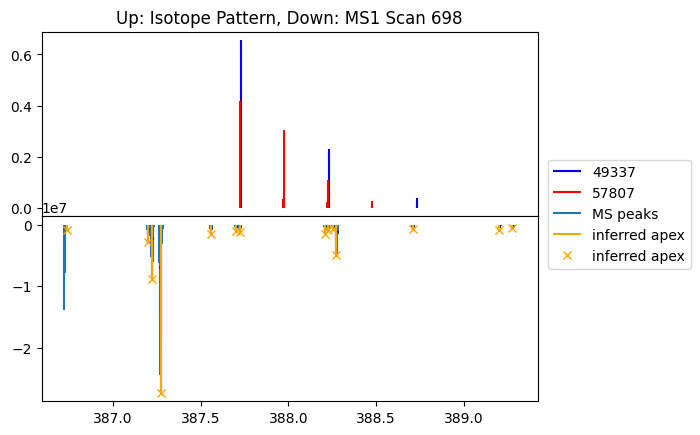

In [111]:
from utils.plot import plot_isopattern_and_obs

# to compare the range of isotope pattern belonging to one precursor
plot_isopattern_and_obs(
    ms1_scans=MS1Scans,
    maxquant_result=Maxquant_result_dict,
    scan_idx=698,
    precursor_id=[155129, 183708],
    log_intensity=False,
)

Peak results:
   apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0           4  602.331362            1  602.318053          7  602.344670   
1          19  602.792989           16  602.779665         22  602.806313   
2          34  603.295166           33  603.290719         36  603.304060   
3          40  603.322466           37  603.308507         43  603.335807   
4          57  603.824686           54  603.811328         59  603.833592   
5          72  604.301405           70  604.292489         73  604.305863   
6          78  604.327839           75  604.314465         81  604.341214   
7          94  605.332510           91  605.319102         97  605.345918   

   peak_width    peak_height  peak_intensity_sum  
0    0.026617  229465.343750        2.931012e+06  
1    0.026648  190367.296875        3.129062e+06  
2    0.013341  664282.382812        3.908905e+06  
3    0.027301  472853.531250        7.134809e+06  
4    0.022263  347014.968750        5

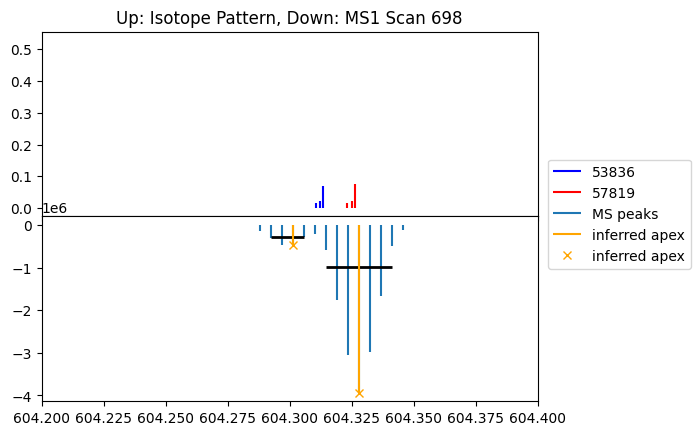

In [98]:
from utils.plot import plot_isopattern_and_obs

# to see peaks in a specific range
plot_isopattern_and_obs(
    ms1_scans=MS1Scans,
    maxquant_result=Maxquant_result_dict,
    scan_idx=698,
    precursor_id=[169722, 183747],
    log_intensity=False,
    mzrange=[604.2, 604.4],
)

# ID and Qunat

## One Scan: an example

In [10]:
# Set config parameters
%autoreload 2
from sbs_runner import _define_rt_search_range

scan_idx =1643
RT_tol = config["RT_tol"]
RT_ref = config["RT_ref"]

# Set left and right edge for scan search range
if "RT_search_left" not in Maxquant_result_dict.columns:
    logging.info("RT search range not defined, defining RT search range.")
    Maxquant_result_dict = _define_rt_search_range(maxquant_result_dict=Maxquant_result_dict, rt_tol=RT_tol, rt_ref=RT_ref)  
                              
# example: generate dictionary for candidate in one scan
OneScan = MS1Scans.iloc[scan_idx, :]

2024-03-20 09:32:32,553 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-03-20 09:32:32,561 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-03-20 09:32:32,564 - matplotlib - DEBUG - interactive is False
2024-03-20 09:32:32,565 - matplotlib - DEBUG - platform is linux
2024-03-20 09:32:32,645 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-03-20 09:32:32,652 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json
2024-03-20 09:32:34.071275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 09:32:35,688 - tensorflow - DEBUG - Falling back to TensorFlow c

## Dictionary

In [14]:
CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (Maxquant_result_dict["RT_search_left"] <= OneScan["starttime"])
    & (Maxquant_result_dict["RT_search_right"] >= OneScan["starttime"])
]

In [17]:
from optimization.dictionary import Dict

scan_specific_dict = Dict(
    candidate_by_rt=CandidatePrecursorsByRT,
    one_scan=OneScan,
    abundance_missing_thres=0.5,
)
scan_specific_dict.get_feature_corr(
    # corr_thres=0.90,
    # plot_collinear_hist=True,
    calc_jaccard_sim=True
)

2024-03-20 11:46:16,917 - optimization.dictionary - INFO - Number of candidates by RT 4376
2024-03-20 11:46:17,014 - optimization.dictionary - INFO - Number of candidates after isotope match 1566
2024-03-20 11:46:17,016 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 529
2024-03-20 11:46:17,143 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 529
2024-03-20 11:46:17,158 - optimization.dictionary - DEBUG - Finished calculating cosine similarity.
2024-03-20 11:46:17,170 - optimization.dictionary - DEBUG - Finished calculating Jaccard similarity.
2024-03-20 11:46:17,271 - optimization.dictionary - INFO - Number of collinear sets: 111 
2024-03-20 11:46:17,272 - optimization.dictionary - INFO - Number of candidates involved in high correlation: 466


In [16]:
dict = scan_specific_dict.dict

In [17]:
a = scan_specific_dict.cos_sim_matrix[51721]
a.describe()

count    529.000000
mean       0.138857
std        0.105297
min        0.012042
25%        0.049971
50%        0.129686
75%        0.223157
max        1.000000
Name: 51721, dtype: float64

In [13]:
high_corr_sol = scan_specific_dict.high_corr_sol
high_corr_set = scan_specific_dict.collinear_sets

In [99]:
from optimization.inference import process_one_scan

Maxquant_result_dict_mod = Maxquant_result_dict.loc[Maxquant_result_dict["id"] != 92843]
scan_result, scan_dict, Quant = process_one_scan(
    scan_idx=scan_idx,
    AbundanceMissingThres=0.5,
    OneScan=OneScan,
    loss="lasso",
    alpha_criteria=config["alpha_criteria"],
    alphas=[0],
    metric="RMSE",
    opt_algo="threshold",
    Maxquant_result=Maxquant_result_dict_mod,
    preprocessing_method="raw",
    # max_iter=250,
    corr_thres=0.95,
    return_interim_results=True,
    plot_alpha_trace=False,
    plot_obs_and_infer=False,
)

2024-02-20 11:36:47,781 - optimization.inference - DEBUG - Start.
2024-02-20 11:36:47,789 - optimization.inference - DEBUG - Filter by RT.
2024-02-20 11:36:47,789 - optimization.dictionary - INFO - Number of candidates by RT 3398
2024-02-20 11:36:47,834 - optimization.dictionary - INFO - Number of candidates after isotope match 1319
2024-02-20 11:36:47,836 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 561
2024-02-20 11:36:47,937 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 561
2024-02-20 11:36:48,658 - optimization.dictionary - INFO - Number of collinear sets: 135 with correlation threshold 0.95
2024-02-20 11:36:48,658 - optimization.dictionary - INFO - Number of candidates involved in high correlation: 361
2024-02-20 11:36:48,659 - optimization.inference - DEBUG - Construct dictionary
2024-02-20 11:36:48,661 - optimization.inference - DEBUG - obs mz (index) dimension: (807,)
2024-02-20 11:36

Show activation of precursors with highly correlated features

In [69]:
a = pd.DataFrame(scan_result[scan_idx]["activation"])
a["cos_dist"] = Quant.calc_precursor_reconstruct_cos_dist()

In [70]:
a[a["precursor"].isin([92843, 131264])]

,precursor,activation,cos_dist
357,131264,2.392114e+07,1.015544


In [ ]:
a[a["precursor"].isin([92843, 131264])]

,precursor,activation,cos_dist
242,92843,2.382890e+07,1.030913
358,131264,2.392114e+07,1.029543


Check out the similarities in groups

In [ ]:
for group in connected_components:
    Maxquant_result_dict.loc[
        Maxquant_result_dict["id"].isin(group),
        ["id", "Calibrated retention time", "IsoMZ", "IsoAbundance"],
    ]
    print("")
Maxquant_result_dict.loc[
    Maxquant_result_dict["id"].isin([1242, 37461, 163787]),
    ["id", "Calibrated retention time", "IsoMZ", "IsoAbundance"],
]

2024-02-14 13:18:35,693 - utils.plot - DEBUG - infer m/z and intensities: Float64Index([ 483.7552822870193,   484.260342599857,  484.3239486651737,
              484.75925050429817, 486.26491183825897],
             dtype='float64'), [7.845553   7.48645162 0.         6.6786551  0.        ]


Isotope Pattern: 27304 [484.26061649 484.75913393 484.7622939  485.25851441 485.26273898
 485.26397132 485.76019183] [0.56715132 0.02073107 0.2474075  0.02538886 0.0174943  0.05261401
 0.01107534]
Isotope Pattern: 38952 [484.2556685  484.75418594 484.75734591 485.25356642 485.25586336
 485.25779099 485.25902333 485.75524384] [0.55524223 0.02435491 0.25432304 0.02485575 0.01115552 0.01370156
 0.05685825 0.01138492]
Isotope Pattern: 39511 [484.2556685  484.75418594 484.75734591 485.25356642 485.25586336
 485.25779099 485.25902333 485.75524384] [0.55524223 0.02435491 0.25432304 0.02485575 0.01115552 0.01370156
 0.05685825 0.01138492]


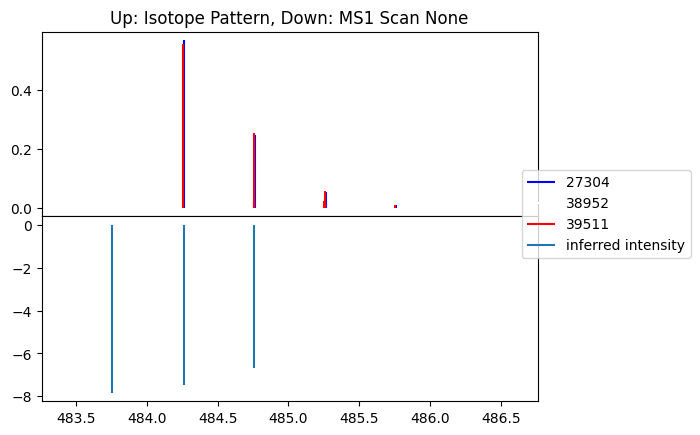

In [86]:
Quant.plot_iso_pattern_and_infer(
    Maxquant_result_dict, precursor_id=[89269, 124835, 127237], log_intensity=True
)

Remove the highly correlated precursors in one group

In [87]:
Maxquant_result_dict_mod = Maxquant_result_dict[
    ~Maxquant_result_dict["id"].isin([124835, 127237])
]
scan_result_mod, scan_dict_mod, Quant_mod = process_one_scan(
    scan_idx=scan_idx,
    AbundanceMissingThres=0.3,
    OneScan=OneScan,
    loss="lasso",
    alpha_criteria=config["alpha_criteria"],
    alphas=[0],
    metric="RMSE",
    opt_algo="threshold",
    Maxquant_result=Maxquant_result_dict_mod,
    preprocessing_method="raw",
    # max_iter=250,
    corr_thres=0.95,
    return_interim_results=True,
    plot_alpha_trace=False,
    plot_obs_and_infer=False,
)

2024-02-14 13:20:13,884 - optimization.inference - DEBUG - Start.
2024-02-14 13:20:13,891 - optimization.inference - DEBUG - Filter by RT.
2024-02-14 13:20:13,892 - optimization.dictionary - INFO - Number of candidates by RT 3294
2024-02-14 13:20:13,942 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2024-02-14 13:20:13,944 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 307
2024-02-14 13:20:13,999 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 307
2024-02-14 13:20:14,209 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 209
2024-02-14 13:20:14,211 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 183
2024-02-14 13:20:14,211 - optimization.inference - DEBUG - Construct dictionary
2024-02-14 13:20:14,213 - optimization.inference - DEBUG - obs mz (index) dimension: (865,)
2024-02-14 13

In [101]:
b = pd.DataFrame(scan_result_mod[scan_idx]["activation"])
b["cos_dist"] = Quant_mod.calc_precursor_reconstruct_cos_dist()
b[b["precursor"].isin([89269, 124835, 127237])]

,precursor,activation,cos_dist
123,89269,4.627801e+06,1.273461


2023-11-22 14:27:03,623 - result_analysis.result_analysis - DEBUG - infer m/z and intensities: Float64Index([688.798643127982, 689.2980074464168], dtype='float64'), [0. 0.]


Isotope Pattern: 14213 [688.800408   689.29892545 689.30208542 689.80060287 689.8025305
 689.80376284 690.30420792 690.30544025] [0.49150318 0.03054204 0.28409012 0.01765338 0.02627883 0.08055331
 0.01518923 0.01493435]


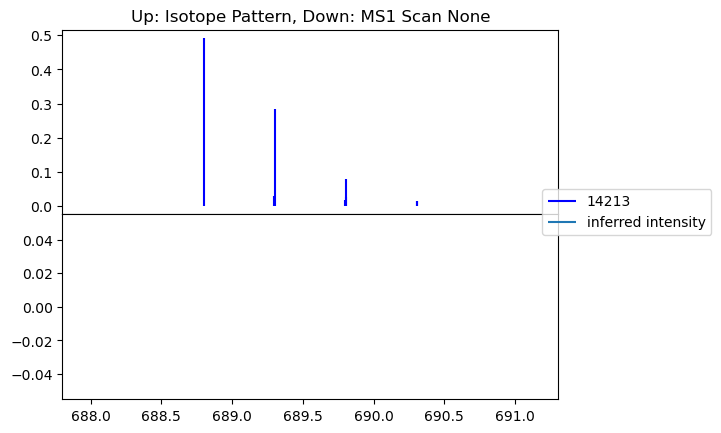

In [109]:
Quant.plot_iso_pattern_and_infer(
    Maxquant_result=Maxquant_result_dict, precursor_id=[44321], log_intensity=False
)

<module 'optimization.dictionary' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/dictionary.py'>

2023-11-22 13:25:32,210 - optimization.dictionary - INFO - Number of candidates by RT 3272
2023-11-22 13:25:32,247 - optimization.dictionary - INFO - Number of candidates after isotope match 1192
2023-11-22 13:25:32,248 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 242
2023-11-22 13:25:32,278 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 242


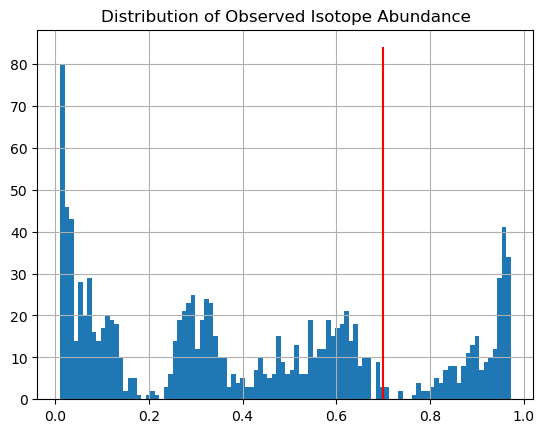

In [15]:
from optimization.dictionary import Dict
import optimization.dictionary

reload(optimization.dictionary)

CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (Maxquant_result_dict["RT_search_left"] <= OneScan["starttime"])
    & (Maxquant_result_dict["RT_search_right"] >= OneScan["starttime"])
]
ScanDict = Dict(
    CandidateByRT=CandidatePrecursorsByRT, OneScan=OneScan, AbundanceMissingThres=0.3
)
ScanDict.plot_observe_iso_abundance_hist()

2023-11-21 13:33:50,617 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


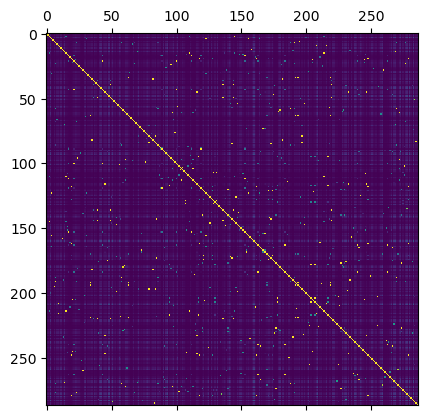

2023-11-21 13:33:51,211 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 141
2023-11-21 13:33:51,212 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 161


In [16]:
%matplotlib inline
ScanDict.get_feature_corr(corr_thres=0.95, plot_collinear_hist=False)

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

Peak results:
     apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0             8  600.296767            5  600.283526         10  600.305595   
1            26  600.631228           23  600.617976         28  600.640063   
2            42  600.962982           40  600.954140         45  600.976246   
3            58  601.259327           56  601.250478         61  601.272600   
4            66  601.294723           63  601.281449         69  601.307997   
..          ...         ...          ...         ...        ...         ...   
288        4273  985.599337         4271  985.580766       4276  985.627194   
289        4291  986.602845         4289  986.584246       4294  986.630745   
290        4307  987.608364         4304  987.580423       4309  987.626993   
291        4322  992.507007         4319  992.478857       4324  992.525774   
292        4336  993.502385         4334  993.483590       4339  993.531192   

     peak_width   peak_height  peak_i

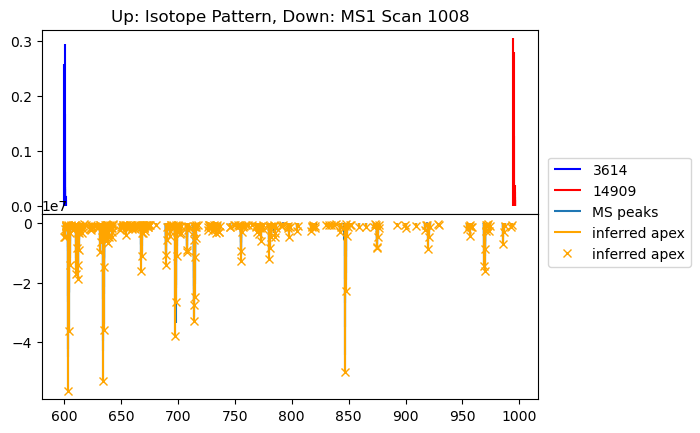

In [17]:
import result_analysis.result_analysis as RA
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

# to see peaks in a specific range
RA.PlotIsoPatternsAndScan(
    scan_idx=1008,
    precursor_idx=[3614, 14909],
    mzrange=None,
    MS1Scans=MS1Scans,
    Maxquant_result=Maxquant_result_dict,
    log_intensity=False,
)

### Explore Isotope Pattern between Sequence

In [18]:
import IsoSpecPy as iso

pair = [4129, 6698]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
4129,_ANGANTVIGPLNWDEK_,2,21.400,14850000.0,849.925926
6698,_CVDTSMGLTPLEGLVMGTR_,2,29.274,124510000.0,1018.994310


OrderedDict([('C', 74), ('H', 113), ('N', 21), ('O', 24), ('S', 0)])

OrderedDict([('C', 82), ('H', 140), ('N', 22), ('O', 27), ('S', 3)])

In [20]:
from optimization.dictionary import CalcModpeptIsopattern

CalcModpeptIsopattern(modpept="_EKVEGTIDK_", charge=2, ab_thres=0.001)

(array([509.77494504, 510.27346248, 510.27662245, 510.27705361,
        510.27808341, 510.7751399 , 510.77706753, 510.77829987,
        510.77873102, 510.77976083, 511.27681732, 511.27874495,
        511.27997729, 511.78042237, 511.78165471]),
 array([0.57300948, 0.02303972, 0.26871023, 0.00372042, 0.00510591,
        0.01080438, 0.02003166, 0.06153999, 0.00174467, 0.00239439,
        0.00247442, 0.00939376, 0.00917221, 0.00215136, 0.00100029]))

## Batch Scan Processing

In [85]:
from optimization.inference import process_scans_parallel, process_one_scan
from multiprocessing import cpu_count
import optimization.inference

reload(optimization.inference)

RT_ref == "mix"
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == "exp":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
    )
elif RT_ref == "pred":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["predicted_RT"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["predicted_RT"] + RT_tol
    )
elif RT_ref == "mix":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Retention time new"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Retention time new"] + RT_tol
    )
result_dict = process_scans_parallel(
    n_jobs=cpu_count(),
    alphas=[0, 100, 1000, 10000, 100000, 1000000],
    AbundanceMissingThres=1.0,
    MS1Scans=MS1Scans.iloc[
        638:646, :
    ],  # for small scale testing: MS1Scans.iloc[1000:1050, :]
    Maxquant_result=Maxquant_result_dict,
    preprocessing_method="raw",
    loss="lasso",
    opt_algo="threshold",
)

<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

True

2023-11-22 14:08:08,394 - optimization.dictionary - INFO - Number of candidates by RT 3274
2023-11-22 14:08:08,436 - optimization.dictionary - INFO - Number of candidates after isotope match 1484
2023-11-22 14:08:08,437 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1484
2023-11-22 14:08:10,352 - optimization.dictionary - INFO - Number of candidates by RT 3273
2023-11-22 14:08:10,407 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2023-11-22 14:08:10,408 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1438
2023-11-22 14:08:11,990 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 106211
2023-11-22 14:08:11,995 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 1116
2023-11-22 14:08:12,014 - optimization.inference - INFO - Reached convergence criteria at alpha = 100
2023-11-22 14:08:12,015 - optimi

In [87]:
# merge results
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(index=Maxquant_result_dict["id"], columns=range(n_ms1scans))
scan_record_list = []
# scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation.loc[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    # scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

In [88]:
a = activation.loc[:, 638:646]

In [141]:
from optimization.inference import process_scans_parallel
from multiprocessing import cpu_count
import optimization.inference

reload(optimization.inference)

RT_ref == "exp"
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == "exp":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
    )
elif RT_ref == "pred":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["predicted_RT"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["predicted_RT"] + RT_tol
    )
result_dict = process_scans_parallel(
    n_jobs=cpu_count(),
    MS1Scans=MS1Scans.iloc[
        1000:1010, :
    ],  # for small scale testing: MS1Scans.iloc[1000:1050, :]
    Maxquant_result=Maxquant_result_dict,
    preprocessing_method="raw",
    AbundanceMissingThres=0.5,
)

<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

False

2023-11-15 13:05:51,097 - optimization.dictionary - INFO - Number of candidates by RT 4638
2023-11-15 13:05:51,157 - optimization.dictionary - INFO - Number of candidates after isotope match 1674
2023-11-15 13:05:51,158 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 636
2023-11-15 13:05:51,779 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 362
2023-11-15 13:05:51,781 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 388
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2089985829642426e+17, tolerance: 415896198849370.4
  model = cd_fast.enet_coordinate_descent_gram(
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: Co

In [138]:
# merge results
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(
    index=Maxquant_result_dict["id"], columns=range(len(result_dict))
)
scan_record_list = []
# scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation.loc[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    # scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

In [60]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
scan_record_list = []
scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    scan_alignments[scan_idx] = result_dict_scan["alignment"]
scan_summary = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

<module 'result_analysis.result_analysis' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

-------------- Intensity -----------------
Non zero intensity in Intensity = 16871
--------------Empty Scans-----------------
-------------- Time_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Time, dtype: float64
-------------- n_CandidateByRT_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_CandidateByRT, dtype: float64
-------------- n_filteredCandidate_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_filteredCandidate, dtype: float64
-------------- preservedRatio_IE_filter_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: preservedRatio_IE_filter, dtype: float64
--------------Non Empty Scans-----------------
Column  Loss do

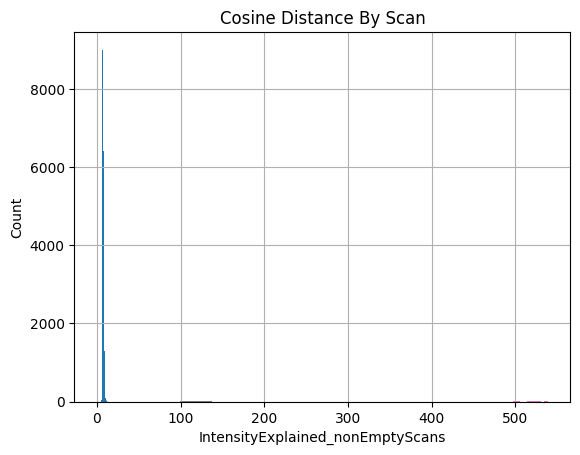

In [26]:
from result_analysis.result_analysis import GenerateResultReport
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

scan_record_processed = GenerateResultReport(
    scan_record=scan_summary, intensity_cols=[Maxquant_result_dict["Intensity"]]
)

In [42]:
from optimization.inference import process_scans
import optimization.inference

reload(optimization.inference)

result_dict = process_scans(
    MS1Scans=MS1Scans.iloc[600:610, :], Maxquant_result=Maxquant_result_dict
)

<module 'optimization.inference' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

2023-11-06 13:53:33,942 - optimization.inference - DEBUG - Current alpha = 1e-05
2023-11-06 13:53:33,945 - optimization.inference - DEBUG - Alpha list [0, 1e-05]
2023-11-06 13:53:33,946 - optimization.inference - DEBUG - Alpha = 1e-05, tol = 0.0005284012636698199
2023-11-06 13:53:33,947 - optimization.inference - DEBUG - Current alpha = 0.0001
2023-11-06 13:53:33,950 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001]
2023-11-06 13:53:33,951 - optimization.inference - DEBUG - Alpha = 0.0001, tol = 0.0
2023-11-06 13:53:33,952 - optimization.inference - DEBUG - Current alpha = 0.001
2023-11-06 13:53:33,954 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001]
2023-11-06 13:53:33,955 - optimization.inference - DEBUG - Alpha = 0.001, tol = 0.0
2023-11-06 13:53:33,957 - optimization.inference - DEBUG - Current alpha = 0.01
2023-11-06 13:53:33,959 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001, 0.01]
2023-11-06 13:53:33,960 - optimizatio

In [ ]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
loss = []
empty_scans = []
ScanProcessRecords = {}
for scan_idx, OneScan in MS1Scans.iterrows():  # scan by scan activation
    CandidatePrecursorsByRT = Maxquant_result_dict.loc[
        (
            Maxquant_result_dict["Calibrated retention time start"] - RT_tol
            <= OneScan["starttime"]
        )
        & (
            Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
            >= OneScan["starttime"]
        )
    ]
    if CandidatePrecursorsByRT.shape[0] > 0:
        (
            CandidateDict,
            CandidatePrecursorsByRT,
            alignment,
            IsotopeNotObs,
            y_true,
            peak_results,
        ) = ConstructDict(CandidatePrecursorsByRT, OneScan, method="peakRange")
        filteredPrecursorIdx = np.array(CandidateDict.columns[1:], dtype=int)
        if CandidateDict.shape[1] > 1:
            (
                activationByScan,
                lossByScan,
                scoreByScan,
                pred,
                explainedInt,
                explainedPeaks,
            ) = CalcPrecursorQuant(
                CandidateDict,
                y_true,
                filteredPrecursorIdx=filteredPrecursorIdx,
                alpha=alpha,
            )
            activation[filteredPrecursorIdx, scan_idx] = activationByScan
            loss.append(lossByScan)
            score.append(scoreByScan)
            RA.PlotTrueAndPredict(
                x=CandidateDict.index,
                prediction=pred,
                true=y_true["intensity"],
                log=True,
            )
        else:
            lossByScan = None
            print(
                "Scan number, start time ",
                scan_idx,
                OneScan["starttime"],
                "does not have valid candidate.",
            )
            empty_scans.append((scan_idx, OneScan["starttime"]))
        ScanProcessRecords[scan_idx] = {
            "CandidatePrecursorIdx": CandidatePrecursorsByRT.index,
            "FilteredCandidatePrecursor": filteredPrecursorIdx,
            "Residue": lossByScan,
            "alignment": alignment,
        }
    else:
        print(
            "Scan number, start time ",
            scan_idx,
            OneScan["starttime"],
            "does not have valid candidate.",
        )

In [ ]:
empty_scans = pd.DataFrame(empty_scans, columns=["Scan", "Time"])

In [ ]:
tmp = activation[:, 2400:2500]
a = tmp.sum(axis=1)
np.array(a > 0).sum()

In [ ]:
activationSumByScan = activation.sum(axis=0)
np.array(activationSumByScan > 0).sum()

In [ ]:
activationSumByPrecursor = activation.sum(axis=1)
np.array(activationSumByPrecursor > 0).sum()

In [ ]:
Intensity_comparison = pd.DataFrame(
    {"MQ_int": Maxquant_result_dict["Intensity"], "Inf_int": activationSumByPrecursor}
)
Intensity_comparison = Intensity_comparison[
    Intensity_comparison["Inf_int"] > 0
].dropna()

In [ ]:
np.save(output_file + "_activationByScanFromLasso.npy", activation)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=range(1650, 1700), y=activation[17754, 1650:1700])